In [1]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from utils.CvTransform import CvResize, CvCenterCrop

import torch.utils.data

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubVideoToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        )
transform = transforms.Compose([CvResize(256),
                                            CvCenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
len(datasets)

Total Drama: 113


39335

In [3]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [4]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [7]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/bken_2layer"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.11.pth")).to(device).eval()

Load lang model: ImgSub2Sub/models/bken_2layer. Word size: 15479


In [11]:
pres, nexs, imgs = getSample(5)

In [16]:
ppres, pnexs, pimgs = pres, nexs, imgs
# ppres = [ppres[0]]*len(ppres)
# pimgs = [pimgs[0]]*len(pimgs)
makes = mutilePredit(ppres, pnexs, pimgs)

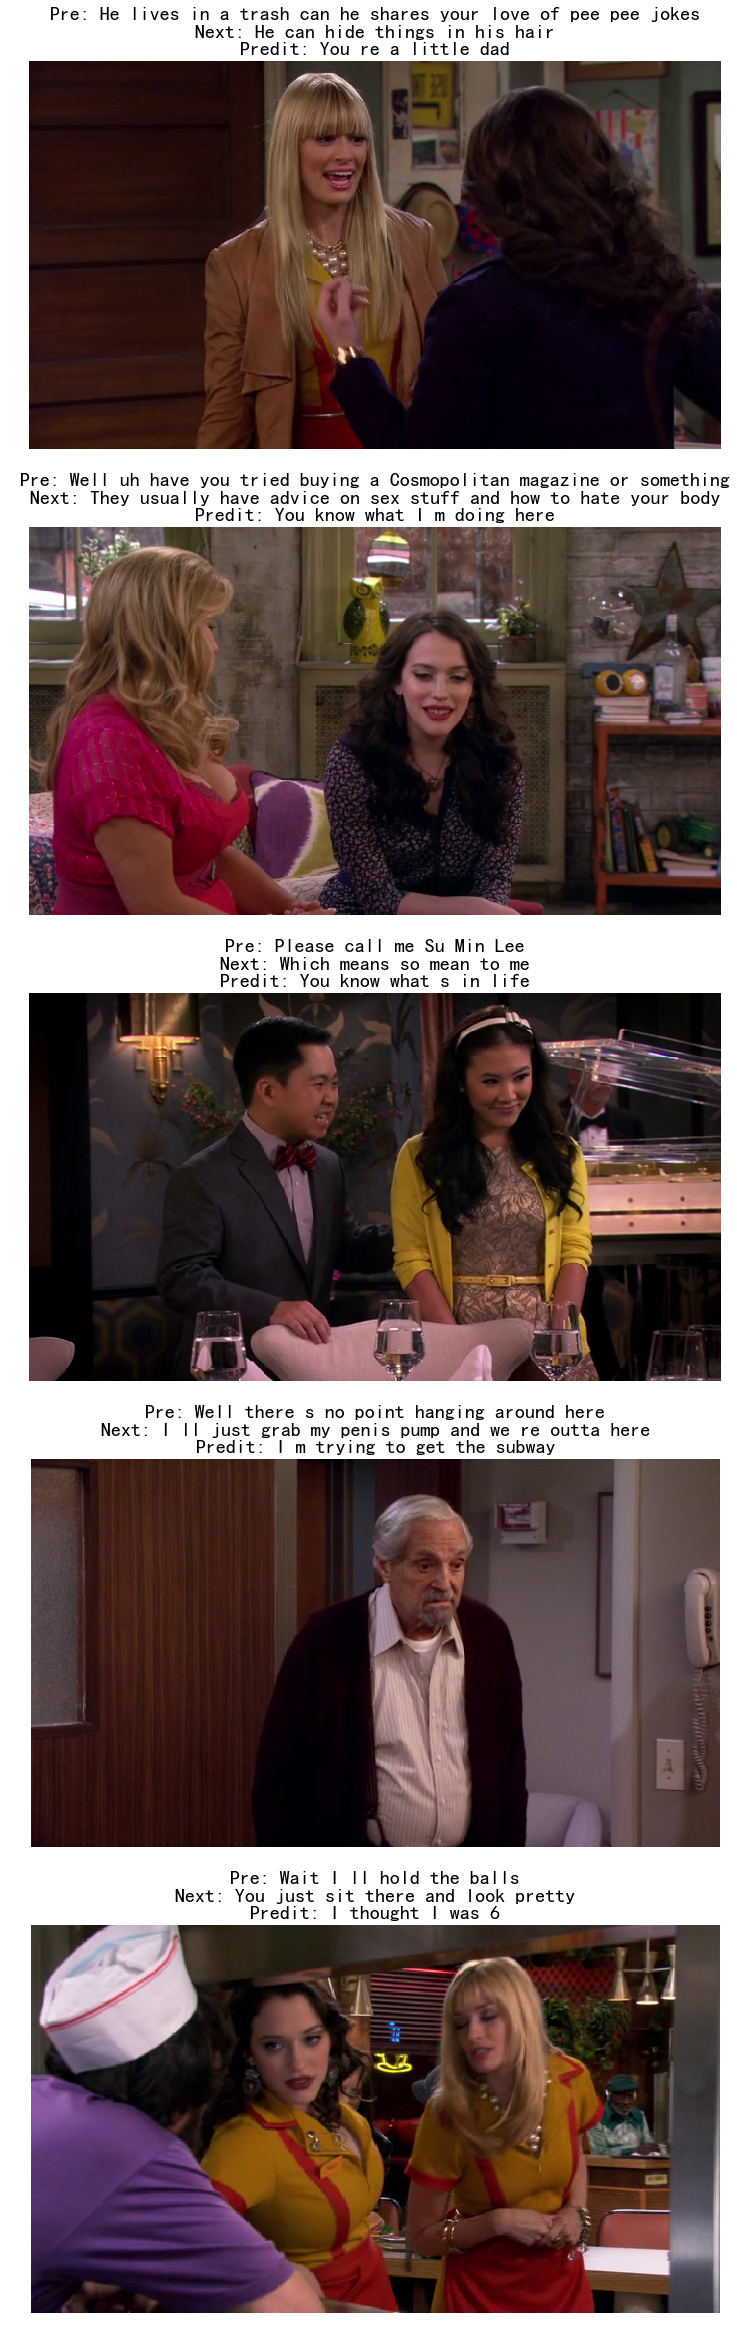

In [17]:
showImgs([ims[0] for ims in pimgs], ppres, pnexs, makes)

In [24]:
import pandas as pd
result = pd.DataFrame([], columns=["pre", "next", "make"])
for _ in range(3):
    pres, nexs, imgs = getSample(48)
    makes = mutilePredit(pres, nexs, imgs)
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    result = result.append(parts,ignore_index=True)

In [25]:
result.to_json("result.json")

In [18]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [19]:
pres, nexs, imgs = getSample(64)

In [20]:
epcoss = []
outputs = []
for i in range(1, 12):
    model = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().item())
    outputs.append(makes)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().item(),
                                             cs.max().item(),
                                             cs.min().item()))
bfOutputs = toBatchFirst(outputs)

Mean: 0.2788, Max: 0.6431, Min: -0.1414
Mean: 0.1763, Max: 0.5776, Min: -0.2849
Mean: 0.1559, Max: 0.5737, Min: -0.2520
Mean: 0.1192, Max: 0.6767, Min: -0.2352
Mean: 0.1116, Max: 0.5898, Min: -0.3634
Mean: 0.0995, Max: 0.4798, Min: -0.3995
Mean: 0.0908, Max: 0.5979, Min: -0.2471
Mean: 0.0716, Max: 0.4959, Min: -0.2377
Mean: 0.0757, Max: 0.5297, Min: -0.3507
Mean: 0.0679, Max: 0.4051, Min: -0.3573
Mean: 0.0677, Max: 0.5710, Min: -0.3238


In [21]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().item())
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().item(),
                                                         cs.max().item(),
                                                         cs.min().item(),
                                                         (cs>=0.7).float().sum().item()))

Mean: 0.0462, Max: 0.3378, Min: -0.3663, Equal: 0.0
Mean: 0.0576, Max: 0.3526, Min: -0.3307, Equal: 0.0
Mean: 0.0796, Max: 0.3940, Min: -0.3184, Equal: 0.0
Mean: 0.0775, Max: 0.5963, Min: -0.2946, Equal: 0.0
Mean: 0.0722, Max: 0.5152, Min: -0.4190, Equal: 0.0
Mean: 0.0813, Max: 0.4270, Min: -0.4190, Equal: 0.0
Mean: 0.0818, Max: 0.5332, Min: -0.2253, Equal: 0.0
Mean: 0.0620, Max: 0.5332, Min: -0.2507, Equal: 0.0
Mean: 0.0740, Max: 0.5332, Min: -0.3318, Equal: 0.0
Mean: 0.0634, Max: 0.4372, Min: -0.3648, Equal: 0.0
Mean: 0.0677, Max: 0.5710, Min: -0.3238, Equal: 0.0


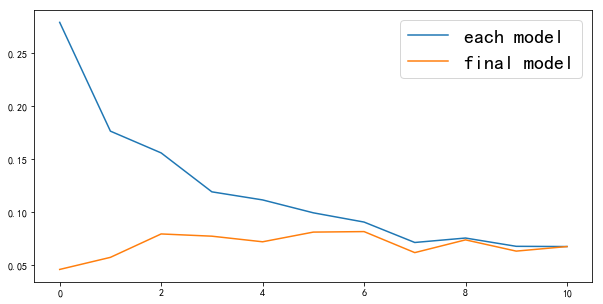

In [22]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

In [21]:
s = pres[60]
s = "we got a problem"
imgs = transform(imgs[60][0]).unsqueeze(0)

In [19]:
predit(model, lang, transform(imgs[60][0]).unsqueeze(0), s)

RuntimeError: invalid argument 2: size '[3 x 3 x 224 x 224]' is invalid for input with 150528 elements at /opt/conda/conda-bld/pytorch_1524580978845/work/aten/src/TH/THStorage.c:41

In [44]:
ans = []
probs = []
inputImgs = imgs.unsqueeze(0)
subtitle = torch.LongTensor(lang.sentenceToVector(s, sos=False, eos=False)).unsqueeze(0)
inputs = torch.LongTensor([[lang["SOS"]]]).long()

inputImgs = Variable(inputImgs.cuda()) if useCuda else Variable(inputImgs)
subtitle = Variable(subtitle.cuda()) if useCuda else Variable(subtitle)
inputs = Variable(inputs.cuda()) if useCuda else Variable(inputs)

hidden = None

cxt = model.makeContext(inputImgs, subtitle)
for i in range(max_length):
    outputs, hidden = modal.decode(inputs, cxt, hidden)
    prob, outputs = outputs.topk(1)
    outputs = outputs[0][0].item()
    probs.append(prob[0][0].item())
    if(outputs == lang["EOS"]):
        break
    ans.append(outputs)
    inputs = Variable(torch.cuda.LongTensor([[outputs]])) if useCuda else Variable(torch.LongTensor([[outputs]]))

AttributeError: 'BatchNorm2d' object has no attribute 'track_running_stats'

Pre: That is a great deal
Next: Max I am not doing this

I m not gonna be a little
I don t want to get you for a couple of time
I don t have to get my hair
I am not going to get on
I just didn t get out of this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this
Max I am not doing this


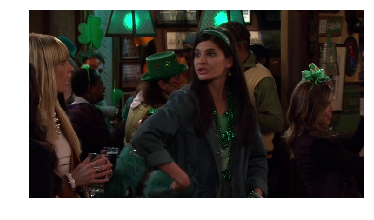

In [63]:
i = 16
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()

In [28]:
import pandas as pd

In [34]:
ps = pd.Series(cs.cpu().data)

In [35]:
ps.describe()

count    64.000000
mean      0.257076
std       0.369989
min      -0.115897
25%       0.024429
50%       0.081752
75%       0.335765
max       1.000000
dtype: float64

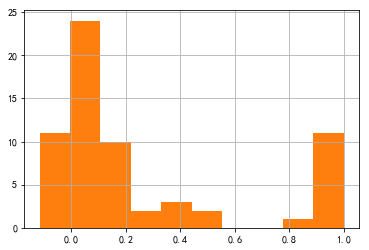

In [38]:
ps.hist()
plt.show()

In [5]:
videoOpt = {
    "cnn_hidden": 1024,
    "hidden_size": 512,
    "output_size": 1024,
    #"num_layers": 1,
    "dropout": 0.1,
    "pretrained": True
}
subencoderOpt = {
    "word_size": len(lang),
    "em_size": 256,
    "num_layers": 2,
    "dropout": 0.1,
    "hidden_size": 256,
    "output_size": 512 
}
decoderOpt = {
    "word_size": len(lang),
    "em_size": 256,
    "num_layers": 2,
    "dropout": 0.1,
    "hidden_size": 256,
    "feature_size": 1024 
}
model = SubVideoToSeq(videoOpt, subencoderOpt, decoderOpt)

/home/ball/anaconda3/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
